In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,InputLayer

In [128]:
df = pd.read_csv('../dataset/gold.csv')
dataset_length = len(df)
df

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,281.0,281.0,281.00,282.7,4,USD
1,2000-01-05,283.2,283.2,283.20,281.1,16,USD
2,2000-01-06,281.4,281.4,281.40,281.4,0,USD
3,2000-01-07,281.9,281.9,281.90,281.9,0,USD
4,2000-01-10,281.7,281.7,281.70,281.7,0,USD
...,...,...,...,...,...,...,...
5757,2022-06-29,1821.4,1834.9,1810.70,1817.5,155542,USD
5758,2022-06-30,1819.2,1826.8,1802.50,1807.3,208898,USD
5759,2022-07-01,1808.1,1813.6,1783.40,1801.5,249489,USD
5760,2022-07-03,1812.5,1814.2,1809.05,1809.1,0,USD


# DATA PREPROCESSING : 
### Making it per month :

In [129]:
df1 = df[['Date','Close']]
df1

,Date,Close
0,2000-01-04,282.7
1,2000-01-05,281.1
2,2000-01-06,281.4
3,2000-01-07,281.9
4,2000-01-10,281.7
...,...,...
5757,2022-06-29,1817.5
5758,2022-06-30,1807.3
5759,2022-07-01,1801.5
5760,2022-07-03,1809.1


In [130]:
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year,month,day = int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=year,month=month,day=day)

In [131]:
df1['Date'] = df1['Date'].apply(str_to_datetime)
df1['Date']

C:\Users\Hamza\AppData\Local\Temp\ipykernel_27432\3241628394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = df1['Date'].apply(str_to_datetime)


0      2000-01-04
1      2000-01-05
2      2000-01-06
3      2000-01-07
4      2000-01-10
          ...    
5757   2022-06-29
5758   2022-06-30
5759   2022-07-01
5760   2022-07-03
5761   2022-07-04
Name: Date, Length: 5762, dtype: datetime64[ns]

In [132]:
df1.index = df1.pop("Date")
df1

,Close
Date,
2000-01-04,282.7
2000-01-05,281.1
2000-01-06,281.4
2000-01-07,281.9
2000-01-10,281.7
...,...
2022-06-29,1817.5
2022-06-30,1807.3
2022-07-01,1801.5


<AxesSubplot:xlabel='Date'>

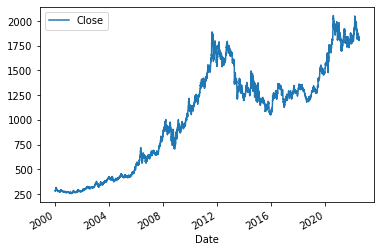

In [133]:
df1.plot()

In [134]:
df1.loc[:"2000-01-10"].tail()

,Close
Date,
2000-01-04,282.7
2000-01-05,281.1
2000-01-06,281.4
2000-01-07,281.9
2000-01-10,281.7


In [135]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    # print(df_subset)
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df


In [136]:
df

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,281.0,281.0,281.00,282.7,4,USD
1,2000-01-05,283.2,283.2,283.20,281.1,16,USD
2,2000-01-06,281.4,281.4,281.40,281.4,0,USD
3,2000-01-07,281.9,281.9,281.90,281.9,0,USD
4,2000-01-10,281.7,281.7,281.70,281.7,0,USD
...,...,...,...,...,...,...,...
5757,2022-06-29,1821.4,1834.9,1810.70,1817.5,155542,USD
5758,2022-06-30,1819.2,1826.8,1802.50,1807.3,208898,USD
5759,2022-07-01,1808.1,1813.6,1783.40,1801.5,249489,USD
5760,2022-07-03,1812.5,1814.2,1809.05,1809.1,0,USD


In [179]:
windowed_df = df_to_windowed_df(df1, 
                                '2000-01-04', 
                                '2022-07-04', 
                                n=9)
windowed_df

Error: Window of size 9 is too large for date 2000-01-04 00:00:00


In [180]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)


dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

AttributeError: 'NoneType' object has no attribute 'to_numpy'

In [181]:
X

array([[[1595.6 ],
        [1594.4 ],
        [1615.6 ],
        ...,
        [1594.2 ],
        [1562.9 ],
        [1539.9 ]],

       [[1615.6 ],
        [1611.9 ],
        [1608.9 ],
        ...,
        [1539.9 ],
        [1565.8 ],
        [1599.7 ]],

       [[1611.9 ],
        [1608.9 ],
        [1604.7 ],
        ...,
        [1565.8 ],
        [1599.7 ],
        [1611.9 ]],

       ...,

       [[1840.55],
        [1838.8 ],
        [1838.4 ],
        ...,
        [1821.2 ],
        [1817.5 ],
        [1807.3 ]],

       [[1838.8 ],
        [1838.4 ],
        [1829.8 ],
        ...,
        [1817.5 ],
        [1807.3 ],
        [1801.5 ]],

       [[1838.4 ],
        [1829.8 ],
        [1830.3 ],
        ...,
        [1807.3 ],
        [1801.5 ],
        [1809.1 ]]], dtype=float32)

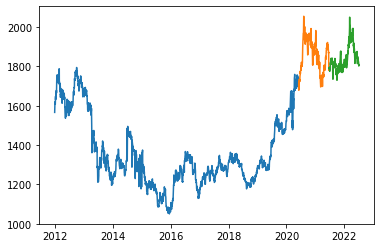

In [182]:
q_80 = int(len(dates)*.8)
q_90 = int(len(dates)*.9)

dates_train,X_train,Y_train = dates[:q_80],X[:q_80],y[:q_80]
dates_val,X_val,Y_val = dates[q_80:q_90],X[q_80:q_90],y[q_80:q_90]
dates_test,X_test,Y_test = dates[q_90:],X[q_90:],y[q_90:]

plt.plot(dates_train,Y_train)
plt.plot(dates_val,Y_val)
plt.plot(dates_test,Y_test)

# Model creation    

In [184]:
model = Sequential()

model.add(InputLayer((9,1)))
model.add(LSTM(64))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mean_absolute_error']
)

In [185]:
## callbacks
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=20, min_lr=0.00001)

In [186]:
model.fit(
    X_train,
    Y_train,
    validation_data=(X_val,Y_val),
    epochs=100,
    callbacks=[reduce_lr]
)

Epoch 1/100
69/69 [==============================] - 4s 21ms/step - loss: 1859391.5000 - mean_absolute_error: 1352.5172 - val_loss: 3425388.0000 - val_mean_absolute_error: 1849.0308 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 1s 10ms/step - loss: 1790313.1250 - mean_absolute_error: 1326.6522 - val_loss: 3243192.5000 - val_mean_absolute_error: 1799.0885 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 1s 12ms/step - loss: 1563998.0000 - mean_absolute_error: 1237.8947 - val_loss: 2770168.5000 - val_mean_absolute_error: 1662.4365 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 1s 12ms/step - loss: 1131222.6250 - mean_absolute_error: 1046.7227 - val_loss: 2006809.2500 - val_mean_absolute_error: 1414.3323 - lr: 0.0010
Epoch 5/100
69/69 [==============================] - 1s 12ms/step - loss: 603375.5000 - mean_absolute_error: 750.8848 - val_loss: 1172197.0000 - val_mean_absolute_error: 1079.6869 - lr: 0.0010
Epoch 6/100
69/69 [========

69/69 [==============================] - 1s 3ms/step


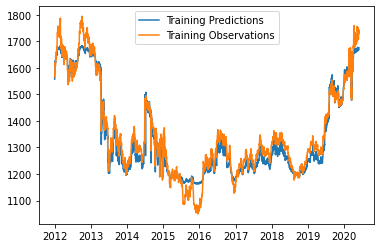

In [187]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.legend(['Training Predictions', 'Training Observations'])

9/9 [==============================] - 0s 4ms/step


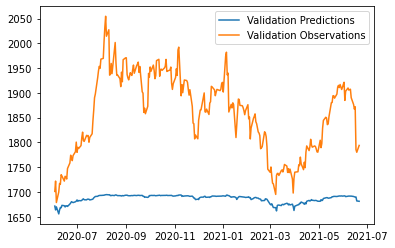

In [188]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

(276, 9, 1)
9/9 [==============================] - 0s 3ms/step


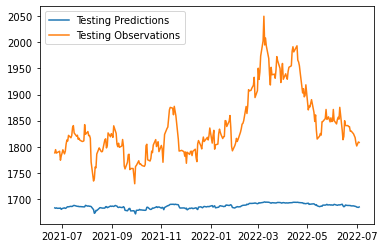

In [189]:
print(X_test.shape)
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [98]:
test_predictions

array([1707.6649, 1708.9656, 1712.1678, 1710.127 , 1699.8849, 1714.6943,
       1710.5807, 1704.7958, 1708.5126, 1712.3763, 1723.1223, 1731.4738,
       1725.8918, 1732.3279, 1737.8585, 1729.3258, 1735.1459, 1732.7806,
       1730.2177, 1720.1196, 1719.536 , 1720.983 , 1729.2167, 1729.8768,
       1725.1536, 1714.1041, 1722.5272, 1703.6733, 1710.1979, 1714.4302,
       1712.0275, 1719.3588, 1719.7181, 1717.6436, 1724.0848, 1725.9359,
       1725.5537, 1734.2706, 1739.4938, 1746.9706, 1748.0446, 1749.1605,
       1755.196 , 1760.5663, 1768.9103, 1764.8331, 1768.9977, 1769.6193,
       1772.7769, 1778.7913, 1783.1718, 1780.1312, 1780.747 , 1785.0919,
       1786.1727, 1787.1345, 1783.5734, 1785.754 , 1787.8942, 1795.1581,
       1801.5062, 1809.0223, 1813.6173, 1822.7628, 1828.6754, 1833.584 ,
       1836.1656, 1840.6709, 1842.7582, 1847.8937, 1851.9764, 1855.2799,
       1853.5579, 1855.7692, 1846.8983, 1846.2147, 1847.451 , 1843.5463,
       1847.553 , 1848.5258, 1844.3617, 1841.4131, 

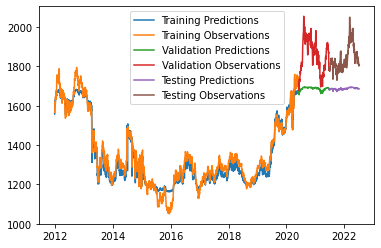

In [190]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [191]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
len_recursive_dates = len(recursive_dates)
recursive_dates

array([Timestamp('2020-06-03 00:00:00'), Timestamp('2020-06-04 00:00:00'),
       Timestamp('2020-06-05 00:00:00'), Timestamp('2020-06-08 00:00:00'),
       Timestamp('2020-06-09 00:00:00'), Timestamp('2020-06-10 00:00:00'),
       Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'),
       Timestamp('2020-06-15 00:00:00'), Timestamp('2020-06-16 00:00:00'),
       Timestamp('2020-06-17 00:00:00'), Timestamp('2020-06-18 00:00:00'),
       Timestamp('2020-06-19 00:00:00'), Timestamp('2020-06-22 00:00:00'),
       Timestamp('2020-06-23 00:00:00'), Timestamp('2020-06-24 00:00:00'),
       Timestamp('2020-06-25 00:00:00'), Timestamp('2020-06-26 00:00:00'),
       Timestamp('2020-06-29 00:00:00'), Timestamp('2020-06-30 00:00:00'),
       Timestamp('2020-07-01 00:00:00'), Timestamp('2020-07-02 00:00:00'),
       Timestamp('2020-07-03 00:00:00'), Timestamp('2020-07-06 00:00:00'),
       Timestamp('2020-07-07 00:00:00'), Timestamp('2020-07-08 00:00:00'),
       Timestamp('2020-07

In [192]:
#empty list :
L = []

#initialise with the last 9 training values :
for el in  X[-1] :
    L.append(el.tolist()[0])

print(L)

[1838.4000244140625, 1829.800048828125, 1830.300048828125, 1824.800048828125, 1821.199951171875, 1817.5, 1807.300048828125, 1801.5, 1809.0999755859375]


In [193]:
#start iteration :
# 1 - predict the next thing
# 2 - append it to L
# 1 - take the [-9:] of the list, and goto 1

def prediction_from_model(value_list,model):
    prediction = model.predict(value_list).flatten()
    return prediction[0]


def get_input_X(in_list):
    return np.reshape(in_list , (1,9,1))


for date in recursive_dates :
    new_list_sample = L[-9:]
    input_X = get_input_X(new_list_sample)
    scalar_prediction = prediction_from_model(input_X,model)
    L.append(scalar_prediction)


1/1 [==============================] - 0s 24ms/step


In [194]:
# get only the new values ( lihouma dial valuation and testing ) :
new_predicted_values = L[9:]
print(f"prediction shape : {np.array(new_predicted_values).shape}")
print(f"recursive_dates shape : {np.array(recursive_dates).shape}")
new_predicted_values

prediction shape : (552,)
recursive_dates shape : (552,)


[1684.7595,
 1657.5991,
 1646.7462,
 1641.6437,
 1639.0779,
 1637.7455,
 1637.0424,
 1636.6681,
 1636.4679,
 1636.3611,
 1636.3035,
 1636.2727,
 1636.256,
 1636.2471,
 1636.2423,
 1636.2399,
 1636.2384,
 1636.2377,
 1636.2373,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636.2372,
 1636

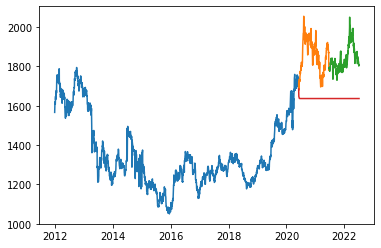

In [195]:
#plot :
plt.plot(dates_train,Y_train)
plt.plot(dates_val,Y_val)
plt.plot(dates_test,Y_test)
plt.plot(recursive_dates,new_predicted_values)
plt.show()